In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

In [23]:
file_path = r"C:\Python\HessiSolarFlare2018.csv"  #2002to2018.csv
df = pd.read_csv(file_path)
formatT = '%Y-%m-%d %H:%M:%S'
df['Datetime'] = pd.to_datetime(df['start.date'] + ' ' + df['start.time'], format=formatT)
df = df.set_index(pd.DatetimeIndex(df['Datetime']))
df = df.drop(columns=['start.date', 'start.time', 'Datetime'])
#df.head()
#organizo en otros dataframes las columnas de duracion.s y energia.kev en orden descendente
Emin = []
Emax = []
Eprom = []
for i in df['energy.kev']:
    result = re.findall(r'[\d\.\d]+', i)
    Emax.append(float(result[1]))
    Emin.append(float(result[0]))
    Eprom.append((float(result[0]) + float(result[1]))/2)
df['EnergiaMin']=Emin
df['EnergiaMax']=Emax
df['EnergiaProm']=Eprom
#saca las flags en distintos dataframes
df1=pd.DataFrame(df.value_counts('flag.1'),columns=['Bandera1']).reset_index()
df2=pd.DataFrame(df.value_counts('flag.2'),columns=['Bandera2']).reset_index()
df3=pd.DataFrame(df.value_counts('flag.3'),columns=['Bandera3']).reset_index()
df4=pd.DataFrame(df.value_counts('flag.4'),columns=['Bandera4']).reset_index()
df5=pd.DataFrame(df.value_counts('flag.5'),columns=['Bandera5']).reset_index()
#print(df5)
#Filtros
Q13=df['flag.3']=="Q1"
Q14=df['flag.4']=="Q1"
Q15=df['flag.5']=="Q1"
dfQ13=df[Q13]
dfQ13
#dfQ1=pd.concat(Q13,Q14,Q15)
#print(dfA1.head(10))
#Mirando los datos y de que tipo son

,flare,peak,end,duration.s,peak.c/s,total.counts,energy.kev,x.pos.asec,y.pos.asec,radial,active.region.ar,flag.1,flag.2,flag.3,flag.4,flag.5,EnergiaMin,EnergiaMax,EnergiaProm
Datetime,,,,,,,,,,,,,,,,,,,
2002-03-07 13:17:16,2030763,13:25:06,13:25:52,516,60,110304.0,6-12,-967,-163,981,9866,A0,P1,Q1,SE,NaN,6.0,12.0,9.0
2002-04-14 19:56:04,2041482,19:57:10,20:00:48,284,2,1322.0,12-25,790,377,875,9893,A0,P1,Q1,SE,NaN,12.0,25.0,18.5
2002-04-16 20:05:48,2041656,20:09:06,20:09:44,236,8,6805.0,6-12,398,-170,434,9906,A0,P1,Q1,SE,NaN,6.0,12.0,9.0
2002-04-17 20:12:52,2041755,20:13:34,20:15:08,136,18,10896.0,12-25,576,-168,600,9906,A1,P1,Q1,SE,NaN,12.0,25.0,18.5
2002-04-25 15:55:40,2042544,15:59:06,16:04:16,516,48,82336.0,6-12,828,273,872,9912,A0,P1,Q1,SE,NaN,6.0,12.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-21 01:55:40,11122199,02:04:50,02:07:48,728,944,588720.0,12-25,-63,-295,302,1382,A0,P1,Q1,SE,NaN,12.0,25.0,18.5
2011-12-21 19:18:36,11122173,19:23:02,19:24:32,356,32,36000.0,6-12,779,335,848,1376,A0,P1,Q1,SE,NaN,6.0,12.0,9.0
2011-12-21 20:57:20,11122181,21:01:14,21:01:28,248,68,27420.0,6-12,783,324,847,1376,A0,P1,Q1,SE,NaN,6.0,12.0,9.0


<AxesSubplot:xlabel='duration.s', ylabel='EnergiaMin'>

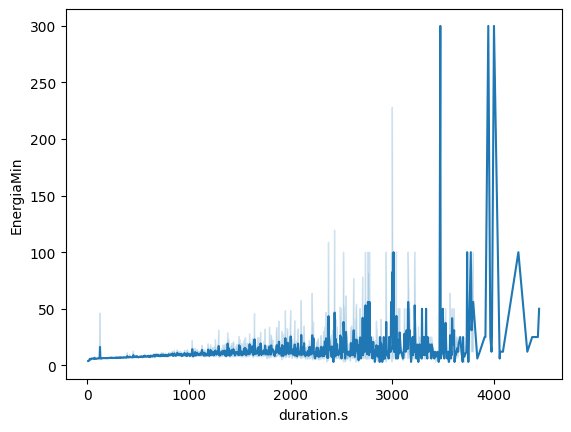

In [29]:
#graficas y analisis de datos
#imprimo la grafica
sns.lineplot(data=df,x='duration.s',y='EnergiaMin')
#sns.displot(data=df, x='')